In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import dill
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as L
from collections import OrderedDict

import sys
sys.path.append("./electric-properties-only")
sys.path.append("./end-to-end")
sys.path.append("./end-to-end-with-feedback")
sys.path.append("../efish-physics-model/objects")
sys.path.append("../efish-physics-model/helper_functions")
sys.path.append("../efish-physics-model/uniform_points_generation")

from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN import EndToEndConvNN
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback import EndToEndConvNNWithFeedback
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 400
data_dir_name = "../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat([models, pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type":"full", "model": [model]})]).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
for folder in list(np.sort(glob.glob("stats-panel/feedback-with-values*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat([models, pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type":"feedback", "model": [model]})]).reset_index(drop=True)

In [7]:
valid_data = dict()
for rand_seed in models["rand_seed"].unique():
    L.seed_everything(rand_seed)
    _, valid_dset = torch.utils.data.random_split(dset, [0.75, 0.25])  # type: ignore
    valid_data[rand_seed] = DataLoader(valid_dset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=12)

Seed set to 11


Seed set to 113


## Summary plots

In [29]:
# models_with_r2 = pd.read_csv("models_with_r2.csv")
models_with_r2 = pd.read_csv("models_with_r2_estimates.csv")
feat_names = [x.split("r2_score_")[1] for x in models_with_r2.columns if "r2_score_" in x]
models_with_r2["num_eods"] = 1
# models_with_r2_multiple_eods = pd.read_csv("models_with_r2_multiple_eods.csv")
models_with_r2_multiple_eods = pd.read_csv("models_with_r2_multiple_eods_estimates.csv")
models_summary = models_with_r2.copy()
num_eods_simulated = [int(x.split("num_eods_")[1]) for x in models_with_r2_multiple_eods.columns if "r2_score_" in x]
for num_eods in num_eods_simulated:
    temp_models = models_with_r2_multiple_eods[["rand_seed", "lambda_RC", "model_type"] + [f"r2_score_{feat_name}_num_eods_{num_eods}" for feat_name in feat_names]].copy()
    for feat_name in feat_names:
        temp_models[f"r2_score_{feat_name}"] = temp_models[f"r2_score_{feat_name}_num_eods_{num_eods}"]
        temp_models.drop(columns=[f"r2_score_{feat_name}_num_eods_{num_eods}"], inplace=True)
    temp_models["num_eods"] = num_eods
    models_summary = pd.concat([models_summary, temp_models]).reset_index(drop=True)

In [30]:
models_summary.head()

,rand_seed,lambda_RC,model_type,r2_score_position_xs,r2_score_position_ys,r2_score_position_zs,r2_score_radii,r2_score_resistances,r2_score_capacitances,num_eods
0,11,0,full,0.936826,0.913133,0.926121,0.792814,-0.162137,-0.068460,1
1,11,1,full,0.956276,0.935520,0.941331,0.829835,0.743767,0.510751,1
2,11,16,full,0.936216,0.894907,0.896426,0.832174,0.796144,0.570400,1
3,11,2,full,0.967962,0.956419,0.955600,0.841929,0.792658,0.547650,1
4,11,4,full,0.959324,0.930390,0.933482,0.852836,0.785830,0.554777,1


/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

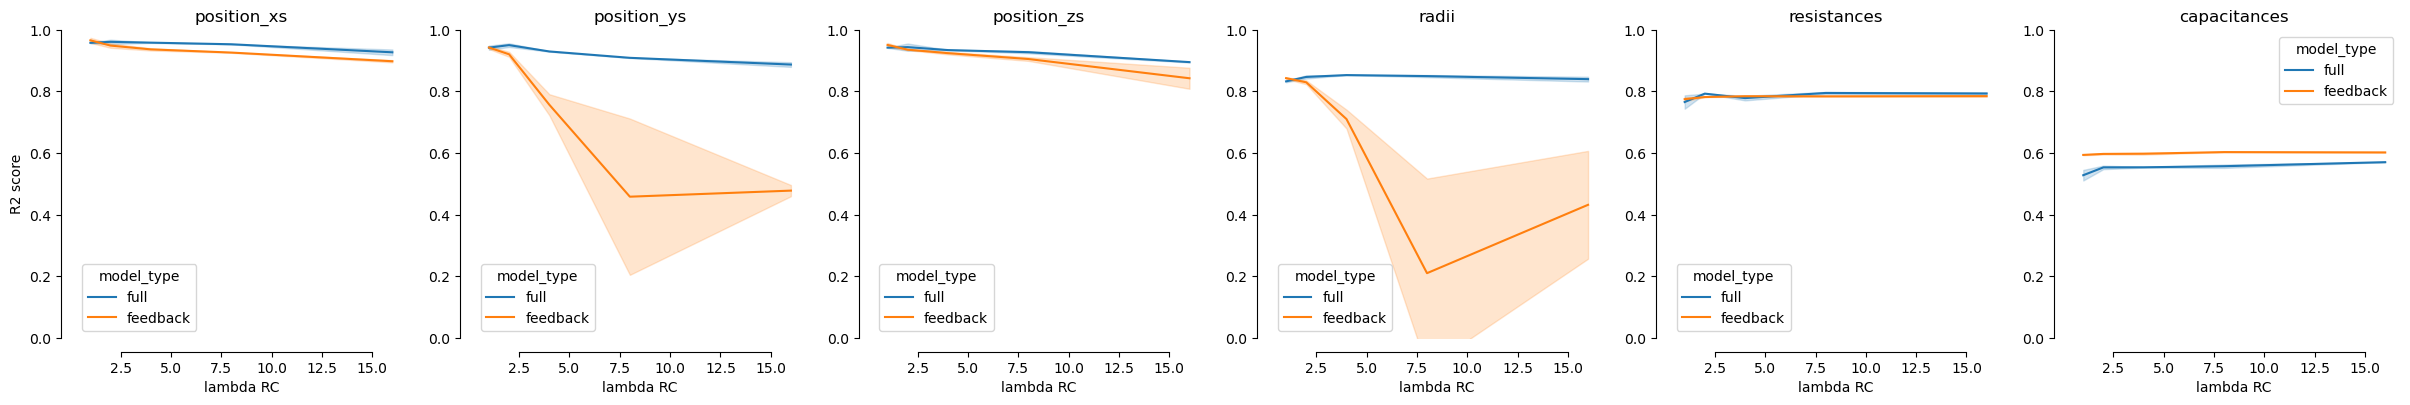

In [31]:
f, axes = plt.subplots(1, len(feat_names), figsize=(5 * len(feat_names), 4))
for i in range(len(feat_names)):
    # axes[i].set_xlim(0,16)
    axes[i].set_ylim(0,1)
    # sns.lineplot(data=models_with_r2, x="lambda_RC", y=f"r2_score_{feat_names[i]}", hue="model_type", ax=axes[i])
    sns.lineplot(data=models_with_r2[models_with_r2["lambda_RC"] > 0], x="lambda_RC", y=f"r2_score_{feat_names[i]}", hue="model_type", ax=axes[i])
    sns.despine(ax=axes[i], offset=10, trim=True)
    if i == 0:
        axes[i].set_ylabel("R2 score")
    else:
        axes[i].set_ylabel("")
    axes[i].set_xlabel("lambda RC")
    axes[i].set_title(feat_names[i])
plt.show()

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

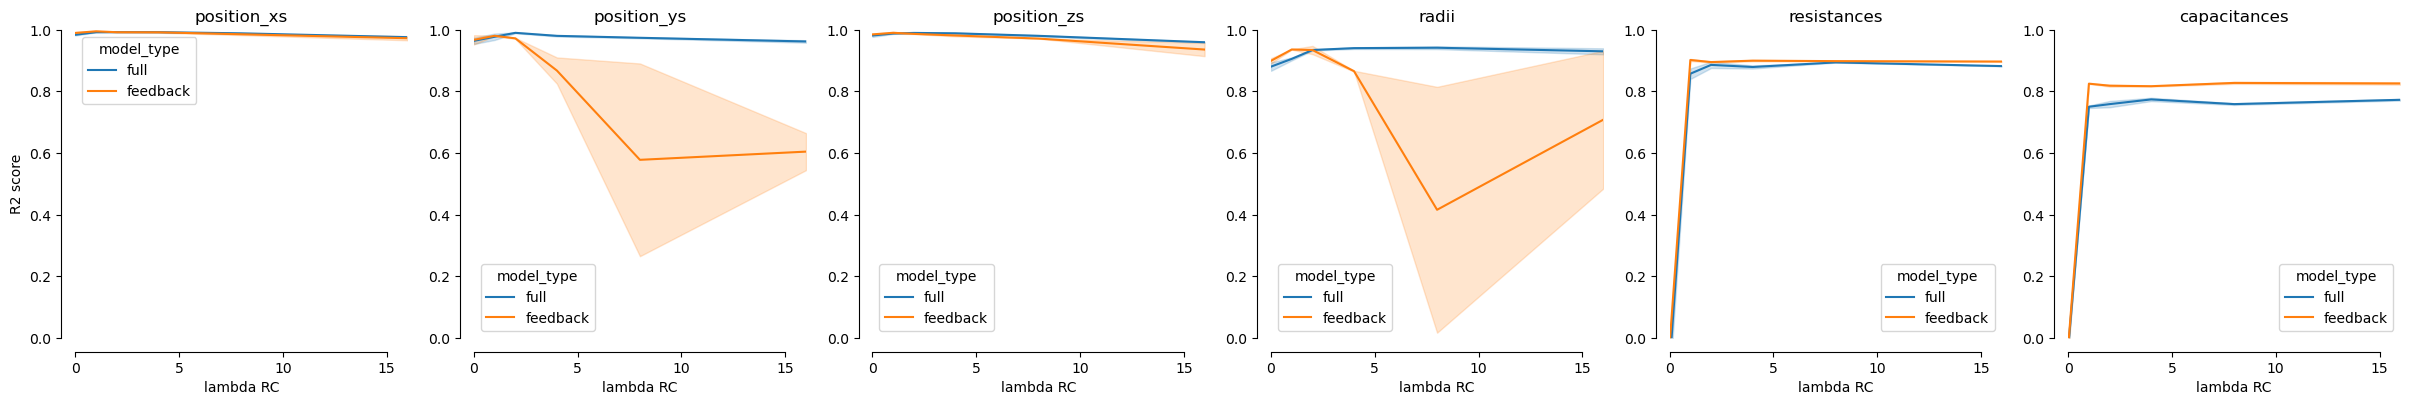

In [32]:
neods = 40
f, axes = plt.subplots(1, len(feat_names), figsize=(5 * len(feat_names), 4))
for i in range(len(feat_names)):
    axes[i].set_ylim(0,1)
    sns.lineplot(data=models_with_r2_multiple_eods, x="lambda_RC", y=f"r2_score_{feat_names[i]}_num_eods_{neods}", hue="model_type", ax=axes[i])
    sns.despine(ax=axes[i], offset=10, trim=True)
    if i == 0:
        axes[i].set_ylabel("R2 score")
    else:
        axes[i].set_ylabel("")
    axes[i].set_xlabel("lambda RC")
    axes[i].set_title(feat_names[i])
    axes[i].set_xlim(0,16)
plt.show()

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

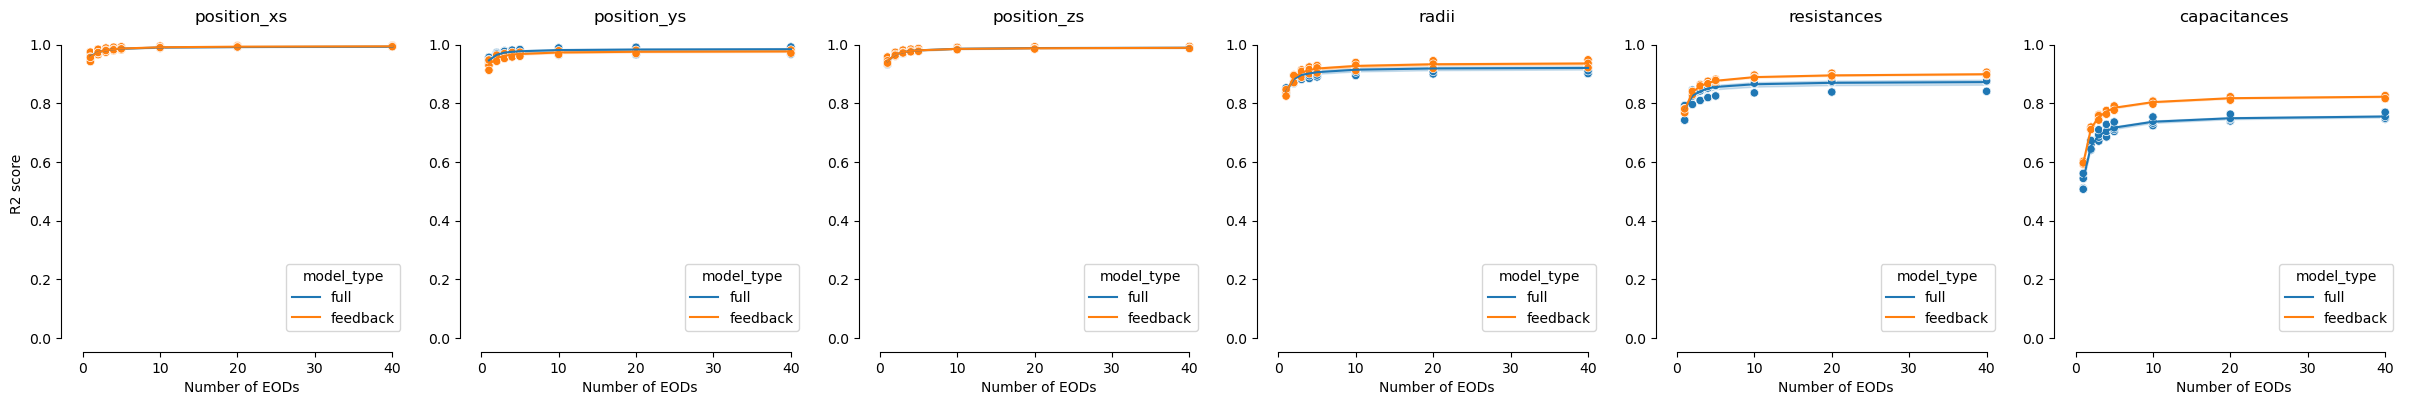

In [33]:
temp_models_summary = models_summary[(models_summary["lambda_RC"] == 1) | (models_summary["lambda_RC"] == 2)]
f, axes = plt.subplots(1, len(feat_names), figsize=(5 * len(feat_names), 4))
for i in range(len(feat_names)):
    axes[i].set_ylim(0, 1.05)
    sns.lineplot(
        data=temp_models_summary,
        x="num_eods",
        y=f"r2_score_{feat_names[i]}",
        hue="model_type",
        ax=axes[i],
    )
    sns.scatterplot(
        data=temp_models_summary,
        x="num_eods",
        y=f"r2_score_{feat_names[i]}",
        hue="model_type",
        ax=axes[i],
        legend=False,
    )
    sns.move_legend(axes[i], "lower right")
    sns.despine(ax=axes[i], offset=10, trim=True)
    if i == 0:
        axes[i].set_ylabel("R2 score")
    else:
        axes[i].set_ylabel("")
    axes[i].set_xlabel("Number of EODs")
    axes[i].set_title(feat_names[i])
plt.show()